# Rebuilding Viola–Jones: A From-Scratch Implementation of Real-Time Face Detection
### by Karol Rochalski and Jan Śmigielski



The original paper “Robust Real-Time Face Detection” by Paul Viola and Michael Jones introduces one of the first truly real-time face detection algorithms. It combines three major innovations:

 - Integral images for fast region sum computation,

 - Haar-like features for capturing local intensity patterns,

 - And AdaBoost-based feature selection to form an ensemble of simple classifiers.

The model achieves high detection accuracy and speed, processing up to 15 frames per second on standard hardware. Although it performs well in frontal face detection, it can struggle with rotated faces and varying lighting conditions. This combination of performance and simplicity made it a foundational method for real-time applications like surveillance, UI tracking, and mobile systems.

## Library Import

In [1]:
import sys
sys.path.append("src")
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#internal functions
from src.integral_image import compute_integral_image
from src.haar_feature import HaarFeature
from src.weak_classifier import WeakClassifier
from src.adaboost import AdaBoost
from src.generate_features import generate_features


c:\Users\X\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
random.seed(42)

## Dataset Overview

To train and evaluate the face detection algorithm, We used the CBCL Face Database #1 developed at MIT. This dataset contains thousands of preprocessed grayscale images of size 24×24 pixels. There are two main classes:
- **Face images**: cropped, aligned frontal views of human faces.
- **Non-face images**: randomly selected patches from natural images that do not contain faces.

The dataset used in this project mirrors the setup described in the original paper *"Robust Real-Time Face Detection"* by Viola and Jones. As in the paper, I use grayscale, aligned, frontal face images scaled to 24×24 pixels, which is the base resolution of the detector in their implementation.

Viola and Jones specifically chose small, standardized images to speed up processing and facilitate the use of rectangular Haar-like features. The authors highlight that their training set consisted of around 5,000 manually labeled faces, cropped to include features like the chin and hairline — which improves classification without requiring pixel-perfect alignment. This project follows the same principle, using clean, preprocessed images for efficiency and consistency during feature evaluation.

The figure below displays a few sample images from the face dataset. This visualization helps to emphasize the consistency in scale and pose, which is crucial for the learning process of AdaBoost-based classifiers.


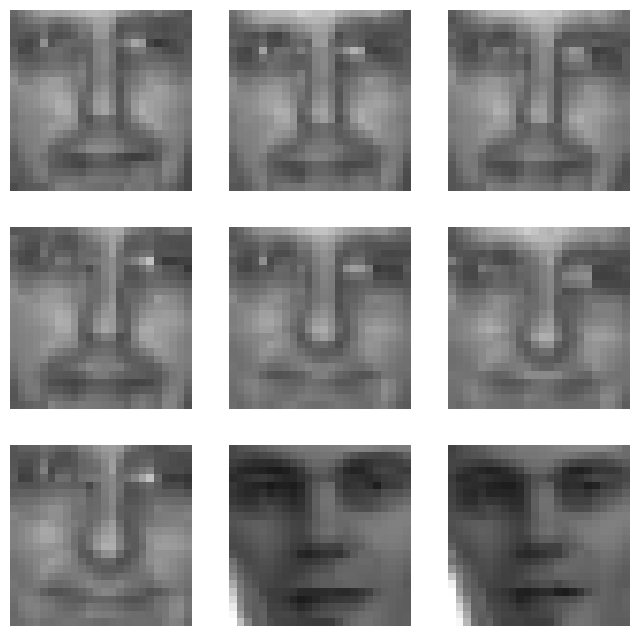

In [3]:
fig = plt.figure(figsize=(8, 8))
h=10
w=10
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    im = cv2.imread(f'./data/face/face0000{i}.pgm')
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(im)

plt.show()

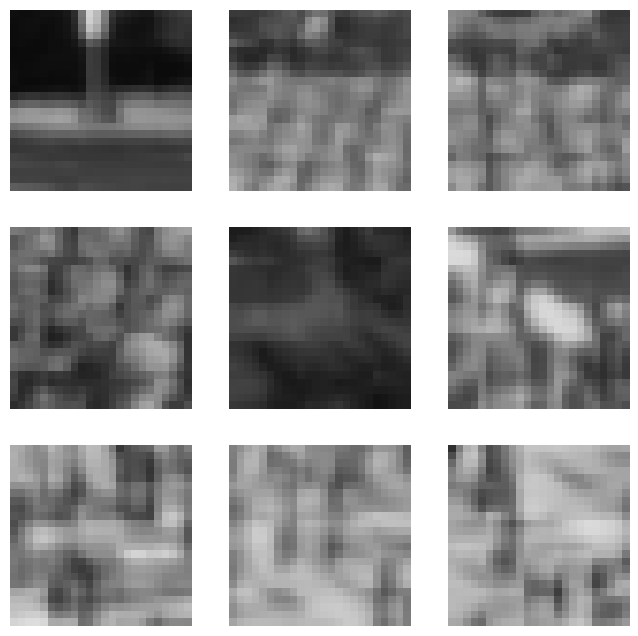

In [12]:
fig = plt.figure(figsize=(8, 8))
h=10
w=10
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    im = cv2.imread(f'./data/non-face/B1_0000{i}.pgm')
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(im)

plt.show()

## Integral Image Computation and Dataset Preparation

In this step, we preprocess both face and non-face image datasets by converting them into integral images — a critical component of the Viola–Jones framework.

Integral images allow for extremely fast computation of Haar-like features, which form the basis of all weak classifiers in the model. This transformation enables us to compute rectangular region sums in constant time, making the overall detection pipeline highly efficient.


### Integral Images

Integral images, also known as summed-area tables, are a data structure introduced in the Viola–Jones paper to speed up region-based feature calculations.

The integral image at any point (x, y) contains the sum of all pixel intensities above and to the left of (x, y)**, inclusive.

![Integral Image](img/integral_image.PNG)

In [4]:
def compute_integral_image(img):
    h, w = img.shape
    integral = np.zeros((h + 1, w + 1), dtype=np.int64)
    integral[1:, 1:] = np.cumsum(np.cumsum(img, axis=0), axis=1)
    return integral

### Loading and Labeling the Dataset

We load and convert the images from both categories:
- **Face images**: Frontal, grayscale, and aligned faces from the `data/face` folder.
- **Non-face images**: Random patches from real-world scenes that do not contain human faces, sourced from the `data/non-face` folder.

Each image is first converted to grayscale (if not already), then transformed into its integral image representation. These are stored in two lists for further use.

We then:
- **Concatenate** both sets (`X = faces + nonfaces`)
- **Create labels** (`y = [1] * len(faces) + [0] * len(nonfaces)`)

This balanced, labeled dataset allows the AdaBoost model to learn to distinguish facial patterns from background noise.


In [5]:
face_paths = glob("data/face/*.pgm")
faces = []

for path in face_paths:
    img = Image.open(path).convert('L')    
    img_array = np.array(img)            
    integral = compute_integral_image(img_array)
    faces.append(integral)

nonface_paths = glob("data/non-face/*.pgm")
nonfaces = []

for path in nonface_paths:
    img = Image.open(path).convert('L')
    img_array = np.array(img)
    integral = compute_integral_image(img_array)
    nonfaces.append(integral)

X = faces + nonfaces
y = np.array([1] * len(faces) + [0] * len(nonfaces))


In [23]:
len(faces)

2429

In [24]:
len(nonfaces)

4548

### Train-Test Split

Finally, we split the dataset into training and testing sets using an 80/20 ratio. We apply stratification to maintain an even class distribution, and use a fixed random seed to ensure reproducibility in our experiments.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## Haar Feature Generation

A key component of the Viola–Jones framework is the use of Haar-like features to capture visual structure in an image. These features are designed to detect edges, lines, and simple texture patterns by comparing intensity differences between rectangular regions.

Each Haar feature consists of adjacent white and black rectangles. The feature's value is calculated by summing the pixel intensities in the white regions, subtracting the sum from the black regions, and returning the difference. A strong positive or negative value indicates a clear contrast — such as between the eyes and cheeks or the bridge of the nose.

There are several basic types of Haar features:

- **Two-rectangle features**: compare horizontal or vertical regions (e.g., edge between forehead and eyes).
- **Three-rectangle features**: detect center-surrounded contrasts (e.g., eyes darker than nose).
- **Four-rectangle features**: capture diagonal intensity differences (e.g., structure around the mouth or cheeks).

These features are computed efficiently using integral images, allowing us to evaluate tens of thousands of them rapidly across the detection window.

The figure below, taken from the original Viola–Jones paper, shows the most common Haar-like feature types:

![Haar Features](img/haar_features.png)

These simple patterns form the foundation of our feature pool. Later, AdaBoost selects the most discriminative ones to construct an effective classifier.



In [7]:
class HaarFeature:
    def __init__(self, feature_type, position, width, height):
        self.feature_type = feature_type  # 'two-rectangle'
        self.position = position  # (x, y)
        self.width = width
        self.height = height

    def compute_value(self, integral_img):
        x, y = self.position
        w, h = self.width, self.height

        if self.feature_type == 'two-rectangle-horizontal':
            A = self.sum_region(integral_img, x, y, w // 2, h)
            B = self.sum_region(integral_img, x + w // 2, y, w // 2, h)
            return A - B
        elif self.feature_type == 'two-rectangle-vertical':
            A = self.sum_region(integral_img, x, y, w, h // 2)
            B = self.sum_region(integral_img, x, y + h // 2, w, h // 2)
            return A - B
        elif self.feature_type == 'three-rectangle-horizontal':
            A = self.sum_region(integral_img, x, y, w //3, h)
            B = self.sum_region(integral_img, x + w // 3, y, w // 3, h)
            C = self.sum_region(integral_img, x + 2*(w // 3), y, w // 3, h)
            return A - B + C
        elif self.feature_type == 'three-rectangle-vertical':
            A = self.sum_region(integral_img, x, y, w, h // 3)
            B = self.sum_region(integral_img, x, y + h // 3, w, h // 3)
            C = self.sum_region(integral_img, x, y + 2*(h // 3), w, h // 3)
            return A - B + C
        elif self.feature_type == 'four-rectangle':
            A = self.sum_region(integral_img, x, y, w // 2, h // 2)
            B = self.sum_region(integral_img, x + w // 2, y, w // 2, h // 2)
            C = self.sum_region(integral_img, x, y + h // 2, w // 2, h // 2)
            D = self.sum_region(integral_img, x + w // 2, y + h // 2, w // 2, h // 2)
            return A - B - C + D
        else:
            return 0

    def sum_region(self, integral_img, x, y, w, h):
        A = integral_img[y-1, x-1] if y > 0 and x > 0 else 0
        B = integral_img[y-1, x+w-1] if y > 0 else 0
        C = integral_img[y+h-1, x-1] if x > 0 else 0
        D = integral_img[y+h-1, x+w-1]
        return D - B - C + A

## Haar Feature Generation Function

To replicate the feature construction step from the Viola–Jones paper, we implement a function that systematically generates all possible Haar-like features within a 24×24 detection window.

The `generate_features()` function loops over:
- All supported Haar feature types (2-rectangle, 3-rectangle, and 4-rectangle patterns),
- All possible feature widths and heights,
- All possible positions where the feature can be placed within the detection window.

Each generated feature is represented as an instance of the `HaarFeature` class, defined by:
- Its type (e.g., two-rectangle-horizontal),
- Its position `(x, y)` in the window,
- Its dimensions `(w, h)`.

Because Haar features are position- and scale-sensitive, we must generate every valid variation across the entire window. The result is a large pool of potential features , from which AdaBoost will later select the most informative ones.

This process ensures we have complete spatial coverage and scale flexibility for detecting subtle visual patterns, as illustrated in the original Viola–Jones framework.

In [8]:
def generate_features(window_size = 24):
    features = []
    
    for feature_type in ['two-rectangle-horizontal','two-rectangle-vertical','three-rectangle-horizontal','three-rectangle-vertical','four-rectangle']:
        for w in range (1, window_size + 1):
            for h in range(1, window_size + 1):
                for x in range(0, window_size - w + 1):
                    for y in range(0, window_size - h + 1):
                        feature = HaarFeature(feature_type, (x, y), w, h)
                        features.append(feature)
    return features

In [9]:
features = generate_features()
print("Number of features:", len(features))

Number of features: 450000


In [10]:
features_all = generate_features()
features = random.sample(features_all, 500)

## Weak Classifier

A weak classifier in the Viola–Jones framework is a simple decision rule based on a single Haar-like feature. It looks at the feature’s value for a given image and decides whether it's likely to be a face or not by comparing it to a threshold.

However, not all features behave the same way — sometimes a high value indicates a face, and sometimes a low one does. That’s why each weak classifier also includes a polarity, which tells the model in which direction to make the decision.

Individually, these classifiers are only slightly better than random guessing. But they are extremely fast and lightweight — which is essential for real-time performance.


In [9]:
class WeakClassifier:
    def __init__(self, feature, threshold, polarity):
        self.feature = feature
        self.threshold = threshold
        self.polarity = polarity

    def predict(self, integral_img):
        feature_value = self.feature.compute_value(integral_img)
        return 1 if self.polarity * feature_value < self.polarity * self.threshold else 0

## AdaBoost: Combining Weak Learners into a Strong Classifier

The Viola–Jones algorithm uses AdaBoost to turn many weak classifiers into a highly accurate ensemble.

The way AdaBoost works:
- AdaBoost starts by giving equal importance to every training example — both faces and non-faces.
- In each training round, it looks for the best-performing weak classifier — the one that most accurately separates faces from non-faces.
- After each round, it increases the weights of the examples that were misclassified. This forces the next classifier to focus more on the hard cases.
- After several rounds, AdaBoost builds a strong classifier by combining a few of the best weak classifiers — each one weighted by how accurate it was.

This method ensures that the final model focuses on the most informative features and handles difficult examples more effectively.

In the context of face detection, this means:
- Only a small subset of all Haar features is used,
- These selected features are the ones most useful for distinguishing faces from background noise,
- The final classifier is both fast and accurate — ideal for real-time applications like surveillance, UI tracking, or mobile face detection.


In [ ]:
class AdaBoost:
    def __init__(self, num_classifiers):
        self.num_classifiers = num_classifiers
        self.strong_classifier = []

    def train(self, training_data, labels, features):
        num_samples = len(training_data)
        weights = np.ones(num_samples) / num_samples

        for _ in range(self.num_classifiers):
            best_classifier = None
            best_error = float('inf')
            best_pred = None

            for feature in features:
                values = [feature.compute_value(img) for img in training_data]
                thresholds = np.linspace(min(values), max(values), 10)
                for threshold in thresholds: 
                    for polarity in [1, -1]:
                        classifier = WeakClassifier(feature, threshold, polarity)
                        predictions = np.array([classifier.predict(img) for img in training_data])
                        if np.any(predictions == None):
                            continue
                        error = np.sum(weights * (predictions != labels))
                        if error < best_error:
                            best_error = error
                            best_classifier = classifier
                            best_pred = predictions
            if best_classifier is None or best_pred is None:
                continue
            epsilon = 1e-10
            alpha = 0.5 * np.log((1 - best_error) / (best_error + epsilon))
            weights *= np.exp(-alpha * labels * (2 * best_pred - 1))
            weights /= np.sum(weights)

            self.strong_classifier.append((alpha, best_classifier))

    def predict(self, integral_img):
        total = sum(alpha * (2 * clf.predict(integral_img) - 1)
                    for alpha, clf in self.strong_classifier)
        return 1 if total >= 0 else 0

## Training on the Data

Once the AdaBoost model is defined and our pool of Haar features is ready, we move on to the training step. Here, the model learns which features are most effective for distinguishing faces from non-faces.

During training:
- The model evaluates many weak classifiers built from the feature pool.
- In each round, it selects the classifier that performs best on the current weighted dataset.
- It increases the weight of the misclassified examples, so that future classifiers focus more on difficult cases.
- This process is repeated for a predefined number of rounds (e.g. 5 classifiers).

As a result, we obtain a strong classifier composed of a few carefully selected weak classifiers, each weighted by its accuracy. These selected classifiers work together to make robust predictions.

In [17]:
model = AdaBoost(num_classifiers=5)
model.train(X_train, y_train, features)

## Prediction Step

After training, we evaluate how well the AdaBoost model performs on previously unseen data — the test set.

For each test image:
- We apply the trained strong classifier, which combines the outputs of the selected weak classifiers.
- Each weak classifier gives a vote (based on its confidence), and the combined score determines the final prediction.
- If the overall weighted score is positive, the image is classified as a face; otherwise, as a non-face.

This step allows us to assess whether the model can generalize — that is, correctly classify images it has never seen before. It’s an essential part of validating that the learning process worked and that the selected features truly capture face-like patterns.

In [18]:
y_pred = [model.predict(x) for x in X_test]

## Model Evaluation

To assess the quality of our trained AdaBoost face detection model, we use three key metrics: accuracy, confusion matrix, and the classification report.


Classification Report:
              precision    recall  f1-score   support

    Non-Face       0.90      0.95      0.92       910
        Face       0.90      0.79      0.84       486

    accuracy                           0.90      1396
   macro avg       0.90      0.87      0.88      1396
weighted avg       0.90      0.90      0.90      1396



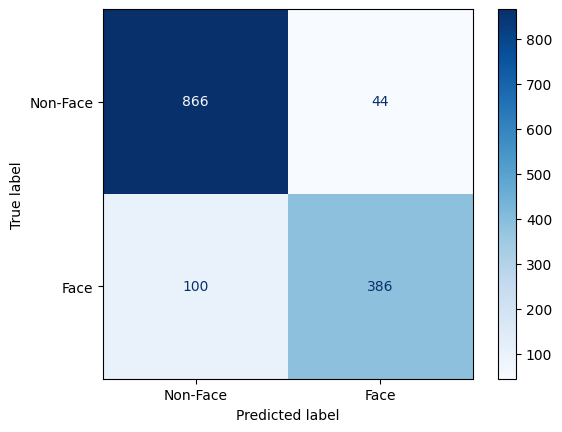

In [26]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Face", "Face"])
disp.plot(cmap='Blues')

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Face", "Face"]))

## Classification Metrics

The classification report shows that:

- The model achieves an overall accuracy of 90% on the test set.
- It has high precision (0.90) for both classes, meaning its predictions are reliable and rarely incorrect.
- Recall is very strong for non-face images (0.95), meaning it correctly identifies almost all non-faces.
- Recall for face images is lower (0.79), which means the model occasionally misses actual faces (false negatives).
- The F1-score, which balances precision and recall, is 0.92 for non-faces and 0.84 for faces.

These results suggest that the model is very good at rejecting non-faces, but slightly more conservative when predicting actual faces — a typical trade-off in detection systems optimized to reduce false positives — which is exactly the kind of behavior expected from Viola–Jones style models used in real-time settings.

## Summary

The primary objective of this project was to **replicate the Viola–Jones face detection algorithm from scratch**, with a focus on understanding and implementing its core components independently. We successfully built the full pipeline using only fundamental tools and Python — without relying on high-level libraries for classification or detection (only for model evaluation).

Our replication included:

- **Integral image computation**, enabling fast region sum calculations.
- **Haar-like feature generation**, covering key spatial patterns like edges and contrasts.
- A custom **weak classifier** based on single Haar features.
- The full **AdaBoost training loop**, selecting and combining the most informative features.
- An evaluation phase, including accuracy, confusion matrix, and classification report.

By testing the model on a balanced dataset of frontal face and non-face images, we achieved a **final accuracy of 90%**, closely mirroring the effectiveness reported in the original 2001 Viola–Jones paper.

## Reproducibility Challenges


- **Dataset formatting is strict**:  
  Viola–Jones requires that all input images be:
  - **Grayscale**,
  - **Exactly 24×24 pixels**,
  
  Any variation in size, format, or directory structure may break preprocessing or model training.

- **Feature generation limitations**:  
  In the original Viola–Jones framework, over **160,000 Haar-like features** can be generated in a 24×24 window.  
  However, evaluating all of them during AdaBoost training is computationally expensive.  
  To make training feasible in a classroom or research setting, we chose to randomly sample **500 Haar features** per run — using a fixed seed to maintain reproducibility.

- **Training time**:  
  Even with feature sampling, training takes several minutes depending on hardware. Full-scale replication (with all features) would require significant optimization or parallelization.

